In [23]:
"""Tutorial on how to create a convolutional autoencoder w/ Tensorflow.

Parag K. Mital, Jan 2016
"""
import tensorflow as tf
import numpy as np
import math
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mean_img = np.mean(mnist.train.images, axis=0)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


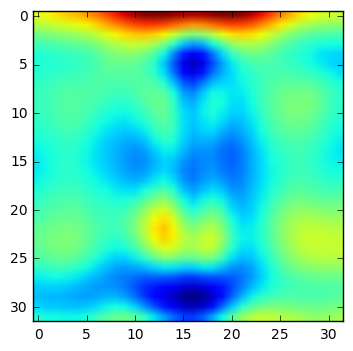

In [43]:
mean_img0 = np.mean(x_train_bw_1, axis=0)
#plt.imshow(mean_img.reshape(28,28))
mean_img0.shape
plt.imshow(mean_img0)

In [44]:
x_train_bw_1.shape,y_train.shape

((73257, 32, 32), (73257, 1))

In [45]:
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox


def visualize(embed, x_test):

    # two ways of visualization: scale to fit [0,1] scale
    # feat = embed - np.min(embed, 0)
    # feat /= np.max(feat, 0)

    # two ways of visualization: leave with original scale
    x_test = x_test.reshape([-1, 28, 28])
    
    embed = embed.reshape([-1, 2])
    
    feat = embed
    ax_min = np.min(embed,0)
    ax_max = np.max(embed,0)
    ax_dist_sq = np.sum((ax_max-ax_min)**2)

    plt.figure()
    ax = plt.subplot(111)
    shown_images = np.array([[1., 1.]])
    for i in range(feat.shape[0]):
        dist = np.sum((feat[i] - shown_images)**2, 1)
        if np.min(dist) < 3e-4*ax_dist_sq:   # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [feat[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(x_test[i], zoom=0.6, cmap=plt.cm.gray_r),
            xy=feat[i], frameon=False
        )
        ax.add_artist(imagebox)

    plt.axis([ax_min[0], ax_max[0], ax_min[1], ax_max[1]])
    # plt.xticks([]), plt.yticks([])
    plt.title('Embedding from the last layer of the network')
    plt.show()


In [46]:
batch_size = 2
#mnist.train.num_examples
k_cluster=10

assign = np.random.choice(k_cluster, batch_size)
#assign_01 = np.zeros((batch_size, k_cluster))
#assign_01[np.arange(batch_size), assign] = 1 
assignment = tf.Variable(assign)
centroids = tf.Variable( np.random.random((k_cluster, 160)))

In [113]:
weights = {
    'wd1': tf.Variable(tf.random_normal([4*4*10, 1024])),
    'wd2': tf.Variable(tf.random_normal([1024, 160])),
    'yx_h1': tf.Variable(tf.random_normal([1024, 256])),
    'yx_h2': tf.Variable(tf.random_normal([256, k_cluster])),
    'yz_h1': tf.Variable(tf.random_normal([160, 64])),
    'yz_h2': tf.Variable(tf.random_normal([64, k_cluster])),
    'zy_h1': tf.Variable(tf.random_normal([160, 160+k_cluster])),
    'zy_h2': tf.Variable(tf.random_normal([160+k_cluster, 160]))
    
}

biases = {
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([160])),
    'yx_b1': tf.Variable(tf.random_normal([256])),
    'yx_b2': tf.Variable(tf.random_normal([k_cluster])),
    'yz_b1': tf.Variable(tf.random_normal([64])),
    'yz_b2': tf.Variable(tf.random_normal([k_cluster])),
    'zy_b1': tf.Variable(tf.random_normal([160+k_cluster])),
    'zy_b2': tf.Variable(tf.random_normal([ 160]))
}


def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float32))

# %%
def autoencoder(input_shape=[None, 32,32],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):

    # input to the network
    x = tf.placeholder(tf.float32, input_shape, name='x')

    x_tensor = tf.reshape(x, [-1, 32,32, 1])
    current_input = x_tensor
    
    # %%
    # Optionally apply denoising autoencoder
    if corruption:
        current_input = corrupt(current_input)

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # store the latent representation
    z = current_input

    # %%
    # Build the decoder using the same weights
    
    encoder.reverse()
    shapes.reverse()
    
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    x_prime = current_input
    # cost function measures pixel-wise difference
    reconstr_cost = tf.reduce_sum(tf.square(x_prime - x_tensor))

    # %%
    return {'x': x, 'z': z, 'x_prime': x_prime, 'reconstr_cost': reconstr_cost}


In [114]:
def update_assignment(assignment, z, N, K):
    data = tf.reshape(z,[N,160])
    means = []
    
    for c in xrange(K):
        means.append(tf.reduce_mean(tf.gather(data,tf.reshape(tf.where(tf.equal(assignment, c)),[1,-1])),reduction_indices=[1]))

    means = tf.reshape(means,[K,160])
    dist_for_each = tf.pow(data - tf.gather(means, assignment),2)
    km_loss = tf.reduce_sum(dist_for_each)- np.log(0.1)
    
    rep_centroids = tf.reshape(tf.tile(means, [N, 1]), [N, K, 160])
    rep_points = tf.reshape(tf.tile(data, [1, K]), [N, K, 160])
    rep_centroids = tf.cast(rep_centroids, tf.float64)
    rep_points = tf.cast(rep_points, tf.float64)
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), 
                                reduction_indices=2)

    # Use argmin to select the lowest-distance point
    new_assignment = tf.argmin(sum_squares, 1)
    
    return km_loss,means,new_assignment

def update_new_batch(centroids, z, N, K):
    data = tf.reshape(z,[N,160])
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 160])
    rep_points = tf.reshape(tf.tile(data, [1, K]), [N, K, 160])
    rep_centroids = tf.cast(rep_centroids, tf.float32)
    rep_points = tf.cast(rep_points, tf.float32)
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), 
                                reduction_indices=2)

    # Use argmin to select the lowest-distance point
    assignment = tf.argmin(sum_squares, 1)
    
    total = tf.unsorted_segment_sum(data, assignment, K)
    count = tf.unsorted_segment_sum(tf.ones_like(data), assignment, K)
    means = total / count
    
    dist_for_each = tf.pow(data - tf.gather(means, assignment),2)
    km_loss = tf.reduce_sum(dist_for_each)- np.log(0.1)
    return km_loss, means, assignment



In [115]:
ae = autoencoder()
learning_rate = 0.01
reconstr_L = ae['reconstr_cost']

km_L0,means,assignment = update_assignment(assignment, ae['z'], batch_size, k_cluster)
loss0 = reconstr_L + 0.2*km_L0 
assignment_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss0)

km_L1,means,assignment = update_new_batch(means, ae['z'], batch_size, k_cluster)
loss1 = reconstr_L + 0.2*km_L1 
new_batch_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss1)

In [116]:
x_train_bw_1.shape,y_train.shape

((73257, 32, 32), (73257, 1))

In [73]:
# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# %%
# Fit all training data
n_epochs = 2
n_itr=2
for epoch_i in range(n_epochs):
    for batch_i in range(2):
        batch_xs = x_train_bw_1[n_itr*batch_size:(n_itr+1)*batch_size]
        batch_ys = y_train[n_itr*batch_size:(n_itr+1)*batch_size]
        train = batch_xs.astype(np.float32)
        for itr_i in range(n_itr): 
            _,mean_tr, ass_tr,reconstr_L_tr,km_L_tr,loss_tr,recon_tr,z_tr = sess.run([assignment_optimizer,means,assignment,reconstr_L,km_L0,loss0,ae['x_prime'],ae['z']], feed_dict={ae['x']: train})
        if batch_i%10 ==0:
            print(epoch_i,batch_i, reconstr_L_tr/batch_size,km_L_tr/batch_size,loss_tr/batch_size)
        _,mean_tr, ass_tr,reconstr_L_tr,km_L_tr,loss_tr,recon_tr,z_tr = sess.run([new_batch_optimizer,means,assignment,reconstr_L,km_L1,loss1,ae['x_prime'],ae['z']], feed_dict={ae['x']: train})
        if batch_i%10 ==0:
            print(epoch_i,batch_i, reconstr_L_tr/batch_size,km_L_tr/batch_size,loss_tr/batch_size)


# %%
# Plot example reconstructions

    test_xs, test_ys = mnist.test.next_batch(batch_size)
    test_xs_norm = np.array([img - mean_img for img in test_xs])
    mean_t, ass_t,reconstr_L_t,km_L_t,loss_t,recon_t,z_t = sess.run([means,assignment,reconstr_L,km_L1,loss1,ae['x_prime'],ae['z']], feed_dict={ae['x']: test_xs_norm})
    print("test: ", epoch_i,reconstr_L_t/batch_size,km_L_t/batch_size,loss_t/batch_size)

sess.close()

In [ ]:
mean_t, ass_t,reconstr_L_t,km_L_t,loss_t,recon_t,z_t

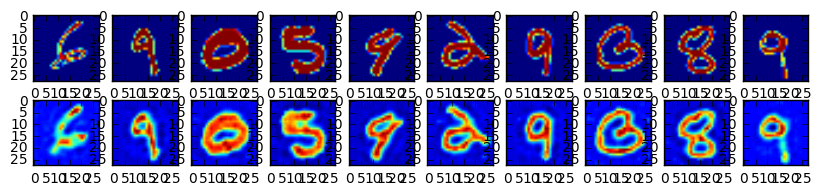

In [29]:
n_examples=10
fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    axs[0][example_i].imshow(
        np.reshape(batch_xs[example_i, :], (28, 28)))
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon_tr[example_i, ...], (1024,)) + mean_img,
            (28, 28)))
fig.show()
plt.draw()

(array([  94.,   31.,   99.,  119.,  100.,  184.,  123.,   75.,  105.,   70.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

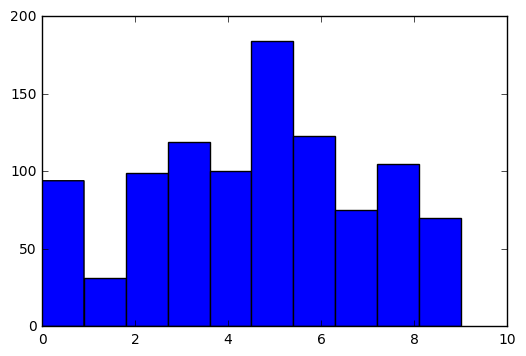

In [31]:
plt.hist(ass_tr)

In [32]:
z_f = []
for i in xrange(z_tr.shape[0]):
    z_f.append(z_tr[i].flatten())
z_f = np.array(z_f)

In [33]:
from sklearn.manifold import TSNE
porj = TSNE(n_components=2).fit_transform(z_f)


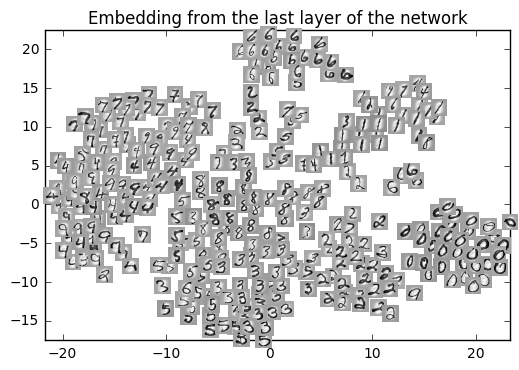

In [34]:
visualize(porj, train)

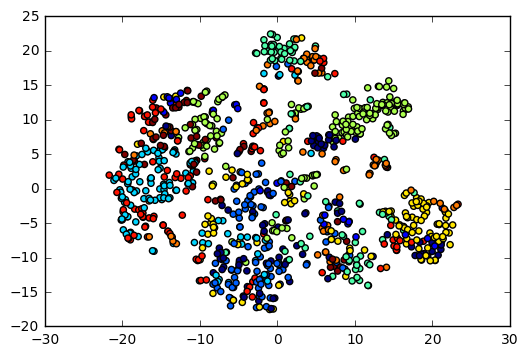

In [35]:
plt.scatter(porj[:,0],porj[:,1],c=ass_tr)

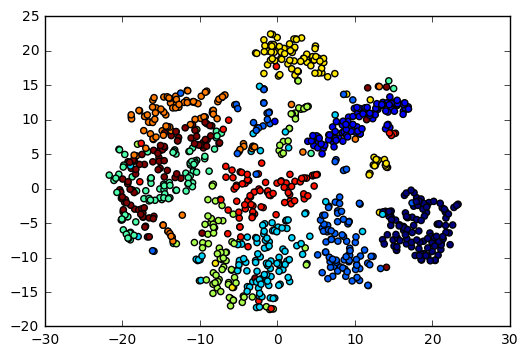

In [36]:
plt.scatter(porj[:,0],porj[:,1],c=np.argmax(batch_ys,1))